<a href="https://colab.research.google.com/github/ThiPauli/Linear-Regression-Health-Costs-Calculator/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-12-10 09:34:11--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0s      

2021-12-10 09:34:12 (113 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [4]:
dataset.shape

(1338, 7)

In [5]:
dataset.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [6]:
#Defining the categorical and numeric columns

CATEGORICAL_COLUMNS = ['sex', 'smoker', 'region']
NUMERIC_COLUMNS = ['age', 'bmi', 'children', 'expenses']

In [7]:
#Creating a df only with the categorical columns
dataset_encoded = dataset.copy()
dataset_categorical =  dataset_encoded.drop(NUMERIC_COLUMNS, axis=1)

In [8]:
dataset_categorical.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


In [9]:
dataset_categorical.shape

(1338, 3)

In [10]:
from sklearn.preprocessing import OrdinalEncoder

# prepare input data
#function to encode our categorical data
def prepare_inputs(data_set):
	oe = OrdinalEncoder()
	oe.fit(data_set)
	X_dataset_enc = oe.transform(data_set)
	return X_dataset_enc

dataset_enc = prepare_inputs(dataset_categorical)

#it returns a numpy array with the same shape from our original dataframe
print(dataset_enc.shape)

(1338, 3)


In [11]:
#Creating a DataFrame with the new encoded data.
dataset_enc = pd.DataFrame(dataset_enc, columns = CATEGORICAL_COLUMNS)

In [12]:
dataset_enc.head()

,sex,smoker,region
0,0.0,1.0,3.0
1,1.0,0.0,2.0
2,1.0,0.0,2.0
3,1.0,0.0,1.0
4,1.0,0.0,1.0


In [13]:
#Assigning the encoded values to the original data frame
dataset_encoded[CATEGORICAL_COLUMNS] = dataset_enc

In [14]:
dataset_encoded.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0.0,27.9,0,1.0,3.0,16884.92
1,18,1.0,33.8,1,0.0,2.0,1725.55
2,28,1.0,33.0,3,0.0,2.0,4449.46
3,33,1.0,22.7,0,0.0,1.0,21984.47
4,32,1.0,28.9,0,0.0,1.0,3866.86


In [15]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [16]:
#Spliting the data (80% training and 20% testing)
train_dataset = dataset_encoded.sample(frac=0.8)
test_dataset = dataset_encoded.drop(train_dataset.index)

#Poping the 'expenses' column
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [17]:
train_dataset.head()

,age,sex,bmi,children,smoker,region
736,37,0.0,38.4,0,1.0,2.0
789,62,0.0,29.9,0,0.0,2.0
1215,18,1.0,39.1,0,0.0,0.0
536,33,0.0,38.9,3,0.0,3.0
1101,53,1.0,28.6,3,0.0,3.0


In [18]:
print(train_dataset.shape)
print(test_dataset.shape)
print(train_labels.shape)
print(test_labels.shape)

(1070, 6)
(268, 6)
(1070,)
(268,)


In [19]:
#Building the model

model = tf.keras.Sequential()
model.add(layers.Dense(24, activation='relu', input_shape=(6,))) #24 nodes and 6 inputs as we have 6 columns of features.
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #1 node and no activation function, because we want to predict the continuous numerical value (expenses)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                168       
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Compile the model:
# Configure the network with optimizer, loss function and accuracy

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                loss='mean_absolute_error',
                metrics=['mae', 'mse']
              )

In [ ]:
#Training the model

history = model.fit(train_dataset, train_labels,
                      validation_data = (test_dataset, test_labels),
                      epochs=100,
                      batch_size=20)

#The output of the training is a history object which records the loss and accuracy metric after each epoch.
#The loss and accuracy metric (mae) is measured for training and validation data set after each epoch.

In [23]:
history_dict = history.history
print(history_dict)

{'loss': [8959.166015625, 6887.375, 6344.73046875, 5373.47314453125, 4101.18896484375, 3906.0244140625, 3687.11474609375, 3806.950439453125, 3883.643798828125, 3758.2216796875, 3521.369873046875, 3743.790771484375, 3486.0576171875, 3764.296142578125, 3429.931884765625, 3332.954345703125, 3401.3798828125, 3343.224853515625, 3383.39697265625, 3314.210205078125, 3685.29736328125, 3262.02001953125, 3333.36474609375, 3287.736328125, 3229.29736328125, 3192.01708984375, 3251.6494140625, 3156.147705078125, 3251.956298828125, 3251.07568359375, 3314.52294921875, 3094.9208984375, 3099.487548828125, 3063.681396484375, 3116.42138671875, 3204.9375, 3185.15185546875, 3078.67236328125, 3033.871337890625, 2944.236328125, 2828.265380859375, 3085.55224609375, 2740.215576171875, 2885.499755859375, 2884.891357421875, 2747.470947265625, 2677.449462890625, 2614.715576171875, 2547.434326171875, 2600.948486328125, 2584.719482421875, 2647.6455078125, 2715.676513671875, 3230.285888671875, 2769.53173828125, 2617.

In [24]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

9/9 - 0s - loss: 2504.0439 - mae: 2504.0439 - mse: 29642778.0000 - 25ms/epoch - 3ms/step


In [25]:
test_dataset.head()

,age,sex,bmi,children,smoker,region
4,32,1.0,28.9,0,0.0,1.0
12,23,1.0,34.4,0,0.0,3.0
20,60,0.0,36.0,0,0.0,0.0
23,34,0.0,31.9,1,1.0,0.0
26,63,0.0,23.1,0,0.0,0.0


In [26]:
test_labels.head()

4      3866.86
12     1826.84
20    13228.85
23    37701.88
26    14451.84
Name: expenses, dtype: float64

In [27]:
test_predictions = model.predict(test_dataset).flatten()

#Checking for the first person in the test_dataset, idx = 4.
print(f"The features of this person is\n{dataset.iloc[4]}.")
print(f"The actual value for the first person in the data set is {test_labels.iloc[0]}.")
print(f"The prediction value for the first person in the data set is {test_predictions[0]:.2f}.")

The features of this person is
age                32
sex              male
bmi              28.9
children            0
smoker             no
region      northwest
expenses      3866.86
Name: 4, dtype: object.
The actual value for the first person in the data set is 3866.86.
The prediction value for the first person in the data set is 3791.57.


9/9 - 0s - loss: 2504.0439 - mae: 2504.0439 - mse: 29642778.0000 - 27ms/epoch - 3ms/step
Testing set Mean Abs Error: 2504.04 expenses
You passed the challenge. Great job!


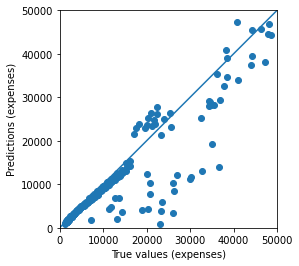

In [28]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
